# Data preprocessing (split to new Notebook later)
Here we throw away simulation data so we can focus on the *scores* only.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42755 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 15.54 GiB


In [4]:
base_path = '../data/parameter_search/2021-03-19/'

no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(base_path + f'{f}_augmented.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(base_path + f'{f}_augmented.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

In [5]:
client.close()

---

In [4]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:37575 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 33.64 GB


In [5]:
root_path = './'
files_prefix = ['A', 'B', 'C']

In [6]:
dfs = []
for f in files_prefix:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')
    df['device_id'] = f
    df['input_excitation'] = df['input_excitation'].astype('int')
    dfs.append(df)
len(dfs)

3

In [7]:
dd.concat(dfs).to_parquet(root_path + 'joined.parquet', engine='pyarrow', partition_on=['device_id', 'input_excitation'], compression='brotli')

In [8]:
client.close()

## Start here

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
df2 = pd.read_parquet('no_curves.parquet/').reset_index(drop=True)
df2.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_similarity,emf_dtw_euclid_norm,emf_dtw_euclid_z_norm,emf_dtw_euclid_joint_z_norm,emf_dtw_dist,y_diff_dtw_euclid_norm,input_excitation,device_id
0,2760,18.700601,133.169589,157.964705,2.921429,0.008333,0.000000,2.5,12.5,30,0.965956,0.048008,722.898276,844.253390,120.308763,0.007427,0,A
1,2761,21.940940,139.772444,196.025229,2.921429,0.008333,0.833333,2.5,12.5,30,0.968712,0.049396,669.396256,848.601250,123.785223,0.007852,0,A
2,2762,21.296333,142.810498,172.046788,2.921429,0.008333,1.666667,2.5,12.5,30,0.966597,0.050194,662.194963,854.744706,125.837050,0.007731,0,A
3,2763,20.414750,147.851987,161.375682,2.921429,0.008333,2.500000,2.5,12.5,30,0.964419,0.050977,728.444711,892.197947,131.826876,0.008095,0,A
4,2764,20.245012,151.665201,169.053189,2.921429,0.008333,3.333333,2.5,12.5,30,0.966203,0.049893,662.403400,912.456302,134.111654,0.008040,0,A


In [41]:
df2_filtered = df2

In [42]:
# Some feature engineering, where we calcute all our objective functions
# TODO: Write these as functions
df2_filtered.loc[:, 'rms_perc_abs'] = np.abs(df2_filtered['rms_perc_diff'])
df2_filtered['dtw_mech'] = df2_filtered['y_diff_dtw_euclid_norm']
df2_filtered['dtw_elec'] = df2_filtered['emf_dtw_euclid_norm']  # Rename takes place here

df2_filtered['dtw_mech_norm'] = (df2_filtered['dtw_mech'] - df2_filtered['dtw_mech'].min())/(df2_filtered['dtw_mech'].max() - df2_filtered['dtw_mech'].min())
df2_filtered['dtw_elec_norm'] = (df2_filtered['dtw_elec'] - df2_filtered['dtw_elec'].min())/(df2_filtered['dtw_elec'].max() - df2_filtered['dtw_elec'].min())

df2_filtered['dtw_both'] = df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['rms_perc_abs_norm'] = (df2_filtered['rms_perc_abs'] - df2_filtered['rms_perc_abs'].min())/(df2_filtered['rms_perc_abs'].max() - df2_filtered['rms_perc_abs'].min())
df2_filtered['rms_dtw_elec'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['balanced'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']

In [43]:
df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_elec,dtw_mech_norm,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
0,2760,18.700601,133.169589,157.964705,2.921429,0.008333,0.000000,2.5,12.5,30,...,A,133.169589,0.007427,0.048008,0.318732,0.013121,0.331853,0.044149,0.057270,0.376002
1,2761,21.940940,139.772444,196.025229,2.921429,0.008333,0.833333,2.5,12.5,30,...,A,139.772444,0.007852,0.049396,0.339531,0.013707,0.353238,0.046338,0.060045,0.399576
2,2762,21.296333,142.810498,172.046788,2.921429,0.008333,1.666667,2.5,12.5,30,...,A,142.810498,0.007731,0.050194,0.333632,0.014044,0.347676,0.047345,0.061389,0.395021
3,2763,20.414750,147.851987,161.375682,2.921429,0.008333,2.500000,2.5,12.5,30,...,A,147.851987,0.008095,0.050977,0.351447,0.014375,0.365822,0.049016,0.063391,0.414838
4,2764,20.245012,151.665201,169.053189,2.921429,0.008333,3.333333,2.5,12.5,30,...,A,151.665201,0.008040,0.049893,0.348759,0.013917,0.362676,0.050280,0.064197,0.412956


In [44]:
# Remove model ids that perform really poorly
# We do this so that we don't skew results by severe outliers that occur due to buggy simulations
criteria = 'rms_perc_diff'
percent_samples = 0.9745  # Outside of 3 standard deviations
cut_off = (1-percent_samples)/2
upper_bound = df2_filtered[criteria].quantile(percent_samples)
lower_bound = df2_filtered[criteria].quantile(1-(percent_samples + cut_off))
print(lower_bound, upper_bound)

to_drop_lower = df2_filtered.query(f'{criteria} < {lower_bound}')['model_id'].values
to_drop_upper = df2_filtered.query(f'{criteria} > {upper_bound}')['model_id'].values

to_drop = np.concatenate([to_drop_lower, to_drop_upper])

df2_filtered = df2_filtered[~df2_filtered['model_id'].isin(to_drop)]

-33.82199699352118 201.7295539350707


In [45]:
len(df2_filtered)

90384

In [46]:
df2_filtered.sort_values(by='rms_perc_diff', ascending=False)

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_elec,dtw_mech_norm,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
2220,1212,29.976435,201.691057,238.946367,1.228571,0.006667,1.666667,2.5,12.5,30,...,A,201.691057,0.011887,0.061908,0.537309,0.018992,0.556302,0.066865,0.085857,0.623167
5493,885,31.514049,201.668216,291.931844,0.664286,0.011667,4.166667,7.5,12.5,30,...,A,201.668216,0.009788,0.063518,0.434425,0.019672,0.454097,0.066858,0.086530,0.520954
2228,1220,22.046254,201.598885,262.354876,1.228571,0.006667,0.000000,5.0,12.5,30,...,A,201.598885,0.008382,0.058785,0.365500,0.017673,0.383173,0.066835,0.084508,0.450008
526,1030,26.339680,201.542077,291.971220,1.228571,0.000000,0.000000,7.5,12.5,30,...,A,201.542077,0.010360,0.054448,0.462467,0.015841,0.478308,0.066816,0.082657,0.545124
3921,1857,26.026751,201.530105,234.116667,1.792857,0.011667,5.833333,0.0,12.5,30,...,A,201.530105,0.009391,0.065043,0.414978,0.020316,0.435294,0.066812,0.087128,0.502106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31647,7359,21.287547,-33.820369,89.884172,8.000000,0.011667,7.500000,0.0,12.5,30,...,A,33.820369,0.005123,0.032969,0.205788,0.006768,0.212556,0.011212,0.017980,0.223768
32989,7369,21.287547,-33.820369,89.884172,8.000000,0.011667,7.500000,2.5,12.5,30,...,A,33.820369,0.005123,0.032969,0.205788,0.006768,0.212556,0.011212,0.017980,0.223768
32999,7379,21.287547,-33.820369,89.884172,8.000000,0.011667,7.500000,5.0,12.5,30,...,A,33.820369,0.005123,0.032969,0.205788,0.006768,0.212556,0.011212,0.017980,0.223768
32563,7399,21.287547,-33.820369,89.884172,8.000000,0.011667,7.500000,10.0,12.5,30,...,A,33.820369,0.005123,0.032969,0.205788,0.006768,0.212556,0.011212,0.017980,0.223768


In [47]:
print(len(df2))
len(df2_filtered)

157500


90384

In [48]:
df2_filtered.query('device_id == "A"').groupby(['input_excitation']).agg({'balanced': 'mean', 'y_diff_dtw_distance': 'mean'}).style.background_gradient(cmap='Reds')

,balanced,y_diff_dtw_distance
input_excitation,,
0,0.295611,17.019855
1,0.187168,15.576448
2,0.139013,15.377729
3,0.172521,14.967042
4,0.136908,14.570082
5,0.148875,14.369017
6,0.140382,14.319610


In [49]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({'y_diff_dtw_distance': 'mean'})
        .sort_values(by='y_diff_dtw_distance', ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

In [50]:
indexes_to_drop = []
for device, num in zip(['A', 'B', 'C'], [2, 2, 2]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    print(to_drop)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)

[0 1]
[6 2]
[2 6]


In [51]:
indexes_to_drop

[Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             14988, 14989, 14991, 14992, 14993, 14994, 14995, 14996, 14998,
             14999],
            dtype='int64', length=8608),
 Int64Index([ 67500,  67501,  67502,  67503,  67504,  67505,  67506,  67507,
              67508,  67509,
             ...
             104947, 104948, 104949, 104950, 104951, 104953, 104963, 104973,
             104983, 104993],
            dtype='int64', length=8608),
 Int64Index([120000, 120001, 120002, 120003, 120009, 120010, 120011, 120012,
             120013, 120019,
             ...
             149990, 149991, 149992, 149993, 149994, 149995, 149996, 149997,
             149998, 149999],
            dtype='int64', length=8608)]

In [52]:
len(df2_filtered)

90384

In [53]:
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)

In [54]:
len(df2_filtered)

64560

In [55]:
df_scores = df2_filtered.groupby(['model_id']).agg({
    'dtw_mech': 'mean',
    'dtw_elec': 'mean',
    'dtw_both': 'mean',
    'rms_perc_abs': 'mean',
    'rms_dtw_elec': 'mean',
    'balanced': 'mean'
})
df_scores.head()

,dtw_mech,dtw_elec,dtw_both,rms_perc_abs,rms_dtw_elec,balanced
model_id,,,,,,
792,0.006383,0.050974,0.281922,61.579344,0.034788,0.302337
793,0.006889,0.053370,0.307729,70.982300,0.038918,0.331261
794,0.007455,0.056539,0.336784,82.428669,0.044051,0.364111
834,0.006722,0.055568,0.300472,76.697150,0.041741,0.325899
842,0.005565,0.048927,0.240949,55.050797,0.031759,0.259199


In [56]:
# Let's get the best performing model ids for each objective_function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'dtw_mech': 5176,
 'dtw_elec': 6166,
 'dtw_both': 5215,
 'rms_perc_abs': 5805,
 'rms_dtw_elec': 5805,
 'balanced': 5215}

In [57]:
best_param_sets = [v for v in best_model_ids.values()]

In [80]:
df2_filtered.query('model_id == 5215')

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_elec,dtw_mech_norm,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
16951,5215,8.996060,9.473343,71.494282,5.742857,0.006667,4.166667,2.5,12.5,30,...,A,9.473343,0.002387,0.032045,0.071655,0.006378,0.078033,0.003141,0.009518,0.081174
29551,5215,6.568871,41.961154,72.598269,5.742857,0.006667,4.166667,2.5,12.5,30,...,A,41.961154,0.001901,0.029238,0.047830,0.005192,0.053022,0.013911,0.019103,0.066933
37219,5215,14.583861,-29.779900,84.996868,5.742857,0.006667,4.166667,2.5,12.5,30,...,A,29.779900,0.003456,0.032668,0.124082,0.006641,0.130723,0.009873,0.016514,0.140596
41803,5215,5.791086,16.280915,79.553437,5.742857,0.006667,4.166667,2.5,12.5,30,...,A,16.280915,0.001687,0.024233,0.037346,0.003078,0.040424,0.005397,0.008476,0.045821
51235,5215,7.385414,21.568858,62.825749,5.742857,0.006667,4.166667,2.5,12.5,30,...,A,21.568858,0.001961,0.023369,0.050757,0.002713,0.053470,0.007151,0.009864,0.060621
58207,5215,7.523908,22.807425,113.683974,5.742857,0.006667,4.166667,2.5,23.5,30,...,B,22.807425,0.003022,0.050715,0.102791,0.014264,0.117055,0.007561,0.021825,0.124617
65203,5215,4.716679,-1.870509,63.334935,5.742857,0.006667,4.166667,2.5,23.5,30,...,B,1.870509,0.001701,0.034457,0.038017,0.007397,0.045413,0.000620,0.008017,0.046034
76039,5215,7.800232,28.981287,165.391807,5.742857,0.006667,4.166667,2.5,23.5,30,...,B,28.981287,0.002753,0.042308,0.089596,0.010713,0.100310,0.009608,0.020321,0.109917
85759,5215,7.979119,9.485026,108.057262,5.742857,0.006667,4.166667,2.5,23.5,30,...,B,9.485026,0.003641,0.051878,0.133107,0.014756,0.147862,0.003144,0.017900,0.151007
92179,5215,4.201611,4.038238,81.239375,5.742857,0.006667,4.166667,2.5,23.5,30,...,B,4.038238,0.001495,0.042252,0.027946,0.010689,0.038636,0.001339,0.012028,0.039974


In [59]:
letters = [r'$A$', r'$B$', r'$C$', r'$D$', r'$E$', r'$F$', 'G']
letter_index = 0
seen_model_ids = []
model_id_to_letter_mapping = {}

for k, v in best_model_ids.items():
    if v not in model_id_to_letter_mapping.keys():
        model_id_to_letter_mapping[v] = letters[letter_index]
        letter_index += 1

In [60]:
model_id_to_letter_mapping 

{5176: '$A$', 6166: '$B$', 5215: '$C$', 5805: '$D$'}

In [61]:
# Just to check
for k, v in best_model_ids.items():
    print(k, model_id_to_letter_mapping[v])

dtw_mech $A$
dtw_elec $B$
dtw_both $C$
rms_perc_abs $D$
rms_dtw_elec $D$
balanced $C$


In [62]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets)]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_letter_mapping[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # To not have latex rendering complain
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.cdc,damper.mdc,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.config.coil.resistance,load.model.R,...,rms.perc.abs,dtw.mech,dtw.elec,dtw.mech.norm,dtw.elec.norm,dtw.both,rms.perc.abs.norm,rms.dtw.elec,balanced,metric.name
16150,6166,9.886746,2.690344,64.725027,6.871429,0.005000,5.000000,2.5,12.5,30,...,2.690344,0.002629,0.030957,0.083498,0.005919,0.089417,0.000892,0.006810,0.090308,$B$
16312,5176,8.354634,12.718315,97.673090,5.742857,0.005000,5.000000,5.0,12.5,30,...,12.718315,0.002217,0.032300,0.063336,0.006486,0.069822,0.004216,0.010702,0.074039,$A$
16951,5215,8.996060,9.473343,71.494282,5.742857,0.006667,4.166667,2.5,12.5,30,...,9.473343,0.002387,0.032045,0.071655,0.006378,0.078033,0.003141,0.009518,0.081174,$C$
19221,5805,11.633436,1.562499,64.880497,6.307143,0.010000,4.166667,0.0,12.5,30,...,1.562499,0.002996,0.032161,0.101510,0.006427,0.107937,0.000518,0.006945,0.108455,$D$
23865,5805,10.073985,27.256161,59.838075,6.307143,0.010000,4.166667,0.0,12.5,30,...,27.256161,0.002865,0.026331,0.095113,0.003964,0.099077,0.009036,0.013000,0.108113,$D$


In [63]:
df_filtered_scores_melt = df_filtered_scores.melt(id_vars=['model.id', 'metric.name'])
df_filtered_scores_melt.head()

,model.id,metric.name,variable,value
0,6166,$B$,y.diff.dtw.distance,9.88675
1,5176,$A$,y.diff.dtw.distance,8.35463
2,5215,$C$,y.diff.dtw.distance,8.99606
3,5805,$D$,y.diff.dtw.distance,11.6334
4,5805,$D$,y.diff.dtw.distance,10.074


In [82]:
df_filtered_scores_melt.to_csv('best_param_set_scores.csv')

In [83]:
df_filtered_scores_melt['variable'].unique()

array(['y.diff.dtw.distance', 'rms.perc.diff', 'emf.dtw.distance',
       'damper.cdc', 'damper.mdc', 'coupling.model.coupling.constant',
       'mechanical.spring.damping.coefficient',
       'coil.config.coil.resistance', 'load.model.R', 'emf.similarity',
       'emf.dtw.euclid.norm', 'emf.dtw.euclid.z.norm',
       'emf.dtw.euclid.joint.z.norm', 'emf.dtw.dist',
       'y.diff.dtw.euclid.norm', 'input.excitation', 'device.id',
       'rms.perc.abs', 'dtw.mech', 'dtw.elec', 'dtw.mech.norm',
       'dtw.elec.norm', 'dtw.both', 'rms.perc.abs.norm', 'rms.dtw.elec',
       'balanced'], dtype=object)

In [66]:
def phd_theme():
    return theme(
        axis_line=element_line(color='black', size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_title_x=element_text(size=16, margin={'t': 12}),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=16),
        axis_text=element_text(size=12),
        panel_background=element_blank(),
        panel_border=element_blank(),
        panel_grid=element_blank(),
        legend_key=element_blank(),
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_position=(0.8, 0.8),
        legend_direction='vertical',
    )

In [67]:
df_filtered_scores_melt.head()

,model.id,metric.name,variable,value
0,6166,$B$,y.diff.dtw.distance,9.88675
1,5176,$A$,y.diff.dtw.distance,8.35463
2,5215,$C$,y.diff.dtw.distance,8.99606
3,5805,$D$,y.diff.dtw.distance,11.6334
4,5805,$D$,y.diff.dtw.distance,10.074


In [68]:
df_filtered_scores_melt[df_filtered_scores_melt['variable'].isin(['dtw.elec', 'dtw.mech', 'rms.perc.diff'])]

,model.id,metric.name,variable,value
60,6166,$B$,rms.perc.diff,2.69034
61,5176,$A$,rms.perc.diff,12.7183
62,5215,$C$,rms.perc.diff,9.47334
63,5805,$D$,rms.perc.diff,1.5625
64,5805,$D$,rms.perc.diff,27.2562
...,...,...,...,...
1195,6166,$B$,dtw.elec,0.0271712
1196,6166,$B$,dtw.elec,0.0226521
1197,5215,$C$,dtw.elec,0.0219064
1198,5176,$A$,dtw.elec,0.0209817


## Draw plot

/home/michael/miniconda3/envs/ds2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


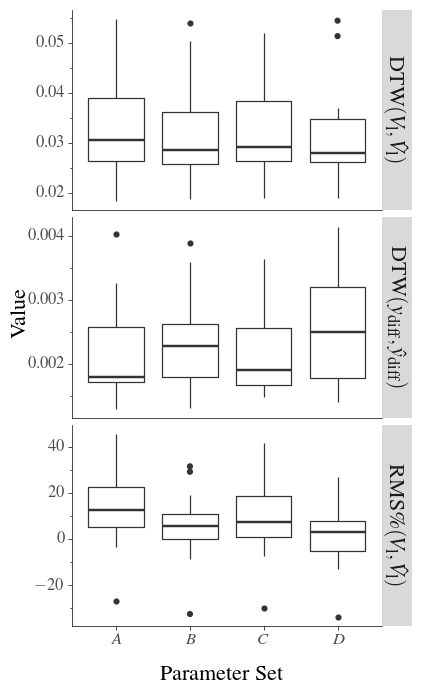

<ggplot: (-9223363301844030071)>

In [70]:
from plotnine import *
from matplotlib import rc
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{amsmath}')
rc('text', usetex=True)

df_plot = df_filtered_scores_melt[df_filtered_scores_melt['variable'].isin(['dtw.elec', 'dtw.mech', 'rms.perc.diff'])]
df_plot['value'] = df_plot['value'].astype(float)

cols_rename = {'dtw.elec': r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$',
               'dtw.mech': r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}})$',
               'rms.perc.diff': r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$'}

lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='metric.name', y='value'), df_plot)
p = (
    p
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free_y', labeller=lblr)
    + phd_theme()
    + theme(figure_size=(4, 8))
    + xlab('Parameter Set')
    + ylab('Value')
)
#p.save('/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

In [36]:
df2_filtered.query('model_id == 1342')

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
21922,1342,30.388581,61.222084,183.158006,1.228571,0.01,1.666667,10.0,12.5,30,...,A,61.222084,30.388581,0.335889,183.158006,0.016887,0.352776,0.020296,0.037183,0.373073
28522,1342,23.473984,133.512130,229.423275,1.228571,0.01,1.666667,10.0,12.5,30,...,A,133.512130,23.473984,0.252391,229.423275,0.022245,0.274636,0.044262,0.066507,0.318898
30406,1342,17.273585,59.580585,176.040880,1.228571,0.01,1.666667,10.0,12.5,30,...,A,59.580585,17.273585,0.177517,176.040880,0.016063,0.193580,0.019752,0.035815,0.213332
40546,1342,17.738593,71.780552,189.088816,1.228571,0.01,1.666667,10.0,12.5,30,...,A,71.780552,17.738593,0.183132,189.088816,0.017574,0.200706,0.023797,0.041371,0.224503
46774,1342,28.178231,112.913444,192.264928,1.228571,0.01,1.666667,10.0,12.5,30,...,A,112.913444,28.178231,0.309198,192.264928,0.017942,0.327140,0.037433,0.055375,0.364573
59446,1342,9.884625,27.326171,203.095160,1.228571,0.01,1.666667,10.0,23.5,30,...,B,27.326171,9.884625,0.088290,203.095160,0.019196,0.107486,0.009059,0.028255,0.116545
63526,1342,5.717507,-16.414650,104.610608,1.228571,0.01,1.666667,10.0,23.5,30,...,B,16.414650,5.717507,0.037970,104.610608,0.007791,0.045761,0.005442,0.013233,0.051202
81322,1342,17.359652,47.494133,216.946987,1.228571,0.01,1.666667,10.0,23.5,30,...,B,47.494133,17.359652,0.178556,216.946987,0.020800,0.199356,0.015745,0.036545,0.215102
84490,1342,23.691237,22.244729,179.307499,1.228571,0.01,1.666667,10.0,23.5,30,...,B,22.244729,23.691237,0.255015,179.307499,0.016441,0.271456,0.007375,0.023816,0.278830
90094,1342,5.706572,-1.890882,130.182269,1.228571,0.01,1.666667,10.0,23.5,30,...,B,1.890882,5.706572,0.037838,130.182269,0.010752,0.048590,0.000627,0.011379,0.049217


In [155]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46199 instead


Client Scheduler: tcp://127.0.0.1:39643 Dashboard: http://127.0.0.1:46199/status,Cluster Workers: 6 Cores: 24 Memory: 33.64 GB


In [156]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

class GroundTruthFactory:
    def __init__(self,
                 samples_list,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            try:
                mech_groundtruth = self._make_mechanical_groundtruth(sample)
                elec_groundtruth = self._make_electrical_groundtruth(sample)

                groundtruths.append(
                    Groundtruth(mech_groundtruth, elec_groundtruth)
                )
            except AttributeError:
                pass

        return groundtruths
# Prepare data
base_groundtruth_path = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [133]:
# Groundtruth

from unified_model.mechanical_components.magnet_assembly import MagnetAssembly
magnet_assembly = MagnetAssembly(
    m=1,
    l_m_mm=10,
    l_mcd_mm=0,
    dia_magnet_mm=10,
    dia_spacer_mm=10,
    mat_magnet='NdFeB',
    mat_spacer='iron'
)

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples[device],
                                            lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                            seconds_per_frame=1/60,
                                                            pixel_scale=0.154508),
                                            adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
    groundtruth[device] = groundtruth_factory.make()

In [134]:
magnet_assembly.get_weight()

0.05778566987196727

In [135]:
# Let's look at some examples from each

In [136]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'time', 'emf', 'y_diff'],
                                filters=[('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp.compute()
    return df_temp.sort_values(by='time')

In [137]:
def compare_mech(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [138]:
def compare_elec(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff}
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x
    return elec_eval

In [139]:
from scipy import signal

{'dtw_distance': 4.683961148231139}


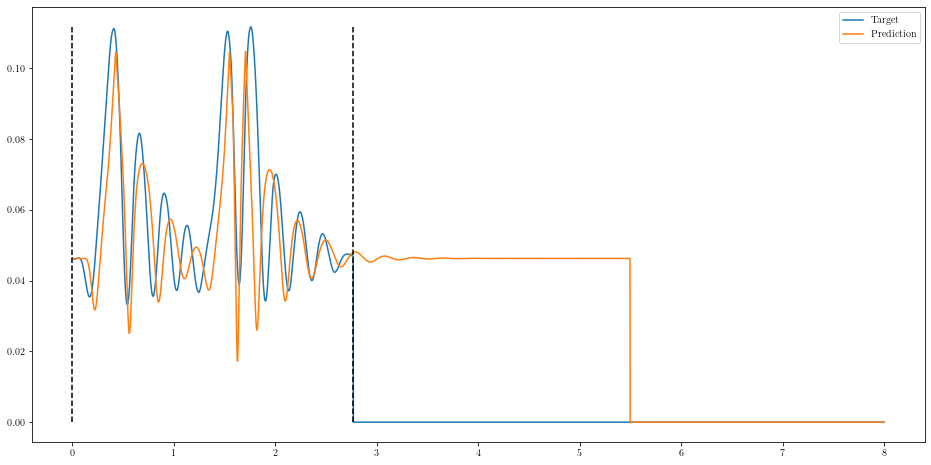

{'dtw_distance': 83.25993032785473, 'rms_perc_diff': 21.80537242067408}


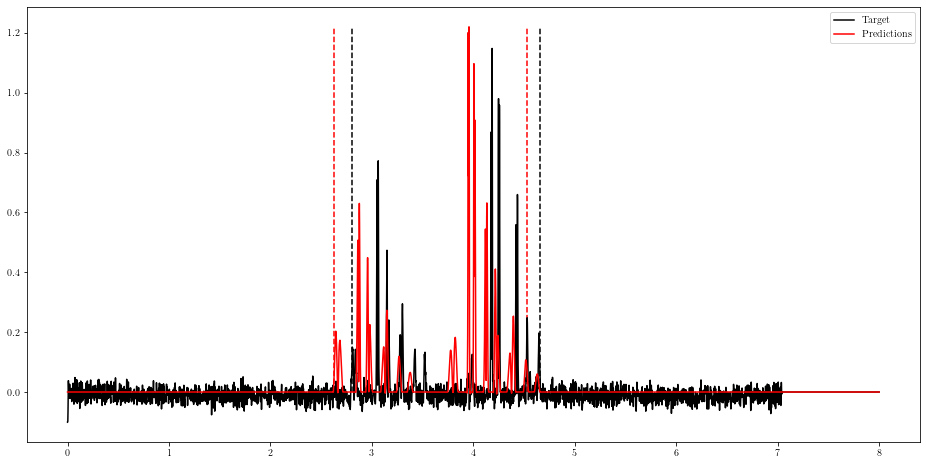

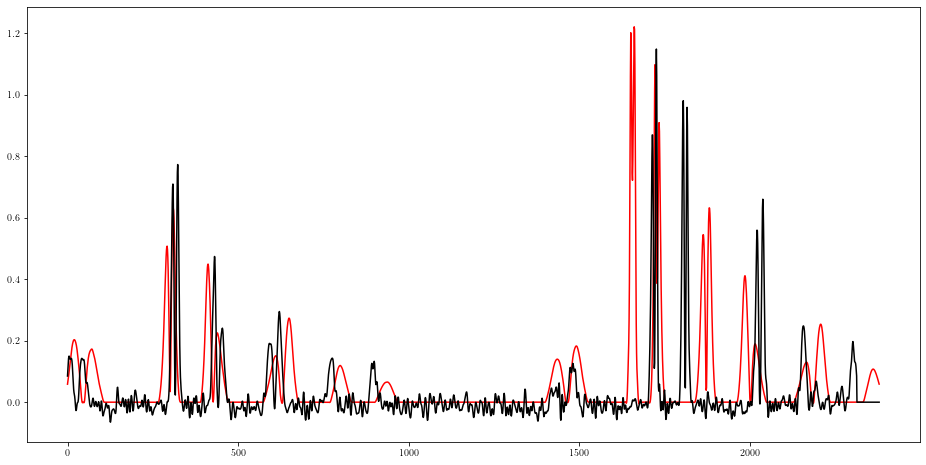

In [146]:
input_ = 5
device = 'A'
chosen_model_id = 5115

compare_mech(f'../output/{device}.parquet', groundtruth, chosen_model_id, device, input_)
ee = compare_elec(f'../output/{device}.parquet', groundtruth, chosen_model_id, device, input_)

plt.figure(figsize=(16, 8))
plt.plot(ee.emf_predict_clipped_, 'r')
plt.plot(ee.emf_target_clipped_, 'k')

In [56]:
emf_target_clipped_ = ee.emf_target_clipped_
emf_predict_clipped_ = ee.emf_predict_clipped_
clip_indexes = ee._clip_indexes

## Correlation investigation

In [49]:
df_sample = get_curve('joined.parquet', 661, 0, 'A')

In [50]:
g = groundtruth['A'][0]

In [51]:
pred_time = df_sample['time'].values
pred_emf = df_sample['emf'].values

truth_time = g.elec.time
truth_emf = g.elec.emf

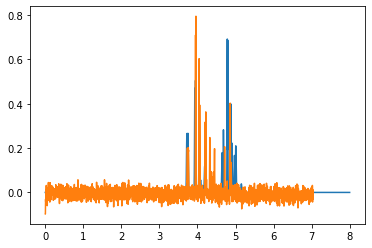

In [52]:
import matplotlib.pyplot as plt
plt.plot(pred_time, pred_emf)
plt.plot(truth_time, truth_emf)

In [56]:
# Start experiment
from scipy import signal
import numpy as np

# sampling periods
sampling_period_pred_time = np.mean(np.gradient(pred_time))
sampling_period_truth_time = np.mean(np.gradient(truth_time))

# Figure out up/down sampling ratio
ratio = sampling_period_pred_time/sampling_period_truth_time
ratio = np.round(ratio, 3)
up = ratio*1e3
down = 1e3

# We need to do a resampling period first
pred_emf_scaled = signal.resample_poly(pred_emf, up, down)

In [57]:
print(ratio)

4.799


In [58]:
pred_time_scaled = np.arange(0., max(pred_time), sampling_period_pred_time/ratio)
pred_time_scaled

array([0.00000000e+00, 6.24953721e-04, 1.24990744e-03, ...,
       7.99753277e+00, 7.99815772e+00, 7.99878268e+00])

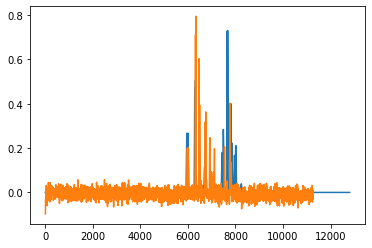

In [59]:
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

12800
12804


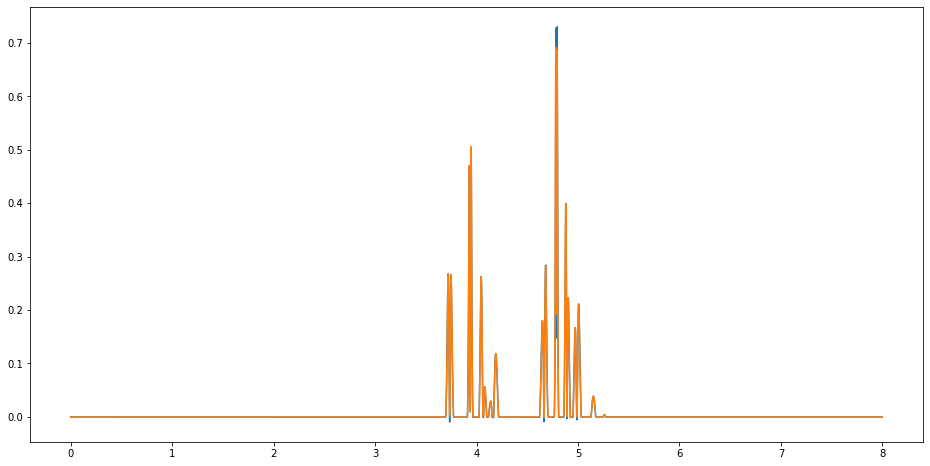

In [61]:
print(len(pred_time_scaled))
print(len(pred_emf_scaled))

# Just make sure any odd samples get clipped
pred_emf_scaled = pred_emf_scaled[:len(pred_time_scaled)]
pred_time_scaled = pred_time_scaled[:len(pred_emf_scaled)]

# Plot
plt.figure(figsize=(16, 8))
plt.plot(pred_time_scaled, pred_emf_scaled)
plt.plot(pred_time, pred_emf)

In [62]:
# Now that we've resampled, we can do correlation
corr_12 = signal.correlate(pred_emf_scaled, truth_emf)
corr_21 = signal.correlate(truth_emf, pred_emf_scaled)

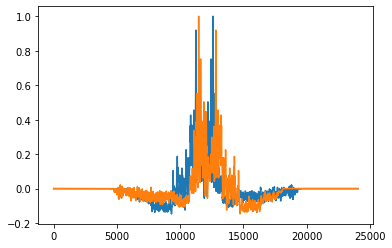

In [63]:
plt.plot(corr_12/max(corr_12))
plt.plot(corr_21/max(corr_21))

In [64]:
first_pos = np.argmax(corr_12)
second_pos = np.argmax(corr_21)

print(first_pos)
print(second_pos)

12599
11463


In [65]:
difference = first_pos - second_pos
difference

1136

In [68]:
if difference < 0:
    padded_pred = np.pad(pred_emf_scaled, (abs(difference), 0), 'constant')
if difference > 0:
    padded_pred = np.pad(pred_emf_scaled, (0, abs(difference)), 'constant')

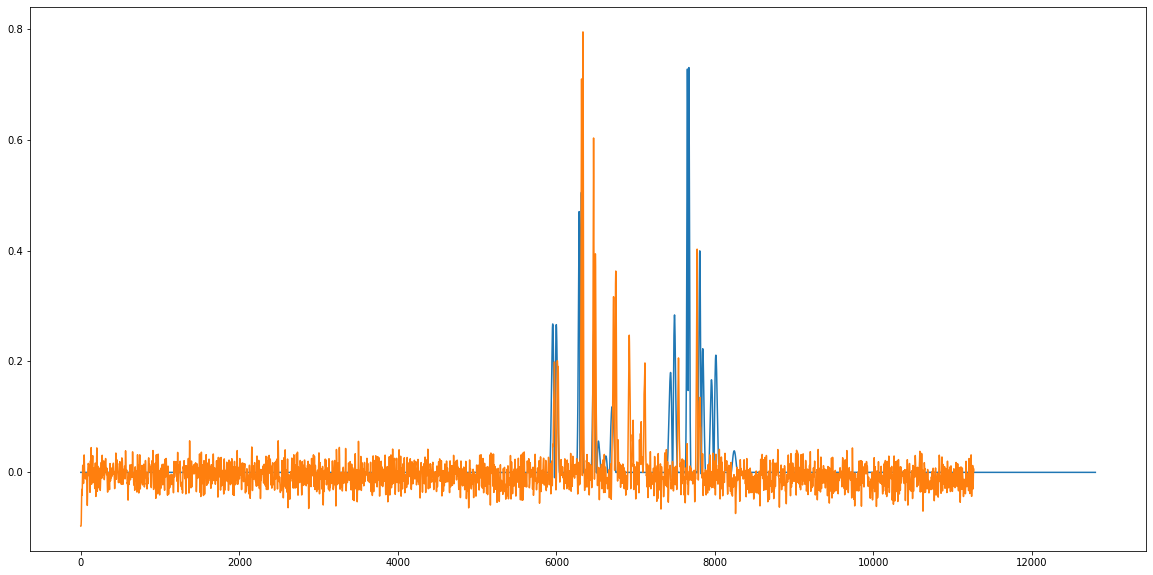

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

In [70]:
from unified_model.utils.utils import find_signal_limits

In [71]:
# Another technique

start_truth, end_truth = find_signal_limits(truth_emf, 0.075)
start_pred, end_pred = find_signal_limits(pred_emf_scaled, 0.05)

In [72]:
start_pred - start_truth

-36

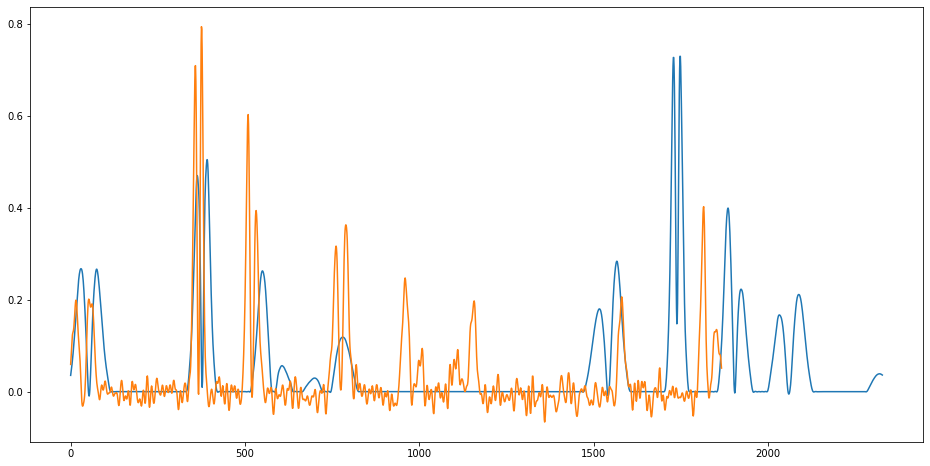

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(pred_emf_scaled[start_pred:end_pred])
plt.plot(truth_emf[start_truth:end_truth])